In [43]:
import os
import torch
import pickle
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image


In [44]:
# prepere for environment, dataset, device
# Detect environment and get num_workers
def get_num_workers():
    """ Dynamically determine num_workers based on the environment. """
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:  # Running in Kaggle
        print("Running on Kaggle environment")
        return min(8, os.cpu_count())  # Kaggle typically provides more CPU cores
    elif 'COLAB_GPU' in os.environ:  # Running in Colab
        print("Running on Colab environment")
        return min(4, os.cpu_count())  # Colab usually has 2 CPU cores in free tier
    else:
        print("Running on a local or unknown environment")
        return min(2, os.cpu_count())  # Default for other environments

num_workers = get_num_workers()


class CustomCIFAR10Dataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.transform = transform
        self.data = []
        self.targets = []

        if train:
            for i in range(1, 6):
                file_path = os.path.join(root, f"data_batch_{i}")
                with open(file_path, "rb") as f:
                    batch = pickle.load(f, encoding="bytes")
                    self.data.append(batch[b"data"])
                    self.targets.extend(batch[b"labels"])
            self.data = np.vstack(self.data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        else:
            file_path = os.path.join(root, "test_batch")
            with open(file_path, "rb") as f:
                batch = pickle.load(f, encoding="bytes")
                self.data = batch[b"data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
                self.targets = batch[b"labels"]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)  
        if self.transform:
            img = self.transform(img)
        return img, target

#Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(),          
    transforms.RandomRotation(15),               
    transforms.ColorJitter(brightness=0.2,       
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                      
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])
# The path points to the extracted folder.
root_path = '/kaggle/input/d/juedu5/deeplearning/cifar-10-batches-py'

trainset = CustomCIFAR10Dataset(root=root_path, train=True, transform=transform_train)
testset = CustomCIFAR10Dataset(root=root_path, train=False, transform=transform_test)

# trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
# testloader = DataLoader(testset, batch_size=128, shuffle=False)


trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=num_workers)

# print(f"Training set size: {len(trainset)}")
# print(f"Testing set size: {len(testset)}")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cpu":
    print("Warning: GPU not available. This will be slow for large datasets.")

Running on Kaggle environment
Using device: cuda


In [28]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [39]:
# Define the CIFAR10 model class
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with probability 0.5
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)  # Output layer for 10 classes
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        #return nn.Softmax(dim=1)(x / self.T)  # Add temperature adjustment
        return x
  

In [45]:
# Function to evaluate the model
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# initial_model start

In [46]:
# Function to train the initial_model
def train_model(model, optimizer, criterion, trainloader, scheduler):
    model.train()
    total_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs) #using forward function
        #outputs = nn.Softmax(dim=1)(model(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    scheduler.step()  # Adjust learning rate based on scheduler
    return total_loss / len(trainloader)


In [47]:
initial_model= CIFAR10Model().to(device)
initial_model.apply(initialize_weights)

CIFAR10Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [48]:
# Initialize the model, loss function, and optimizer

criterion = nn.CrossEntropyLoss()
initial_lr = 0.01
initial_momentum = 0.9

# Setup optimizer and scheduler
optimizer = optim.SGD(initial_model.parameters(), lr=initial_lr, momentum=initial_momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses = []
test_accuracies = []
learning_rates = []
momentum_values = []
current_momentum = initial_momentum  # Initialize current momentum

# # Train the Initial Model for 50 epochs
print("Training Initial Model...")

for epoch in range(50):
    # Adjust learning rate dynamically (scheduler already handles this)
    current_lr = optimizer.param_groups[0]['lr']

    # Adjust momentum dynamically every 10 epochs
    if epoch % 10 == 0:
        current_momentum = max(initial_momentum * (0.5 ** (epoch // 10)), 0.1)
        for param_group in optimizer.param_groups:
            param_group['momentum'] = current_momentum

    train_loss = train_model(initial_model, optimizer, criterion, trainloader, scheduler)
    test_accuracy = evaluate_model(initial_model, testloader)

    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)
    learning_rates.append(current_lr)
    momentum_values.append(current_momentum)

    print(f"Epoch {epoch+1}, LR: {current_lr:.5f}, Momentum: {current_momentum:.5f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Training Initial Model...
Epoch 1, LR: 0.01000, Momentum: 0.90000, Train Loss: 2.0772, Test Accuracy: 38.88%
Epoch 2, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.7695, Test Accuracy: 46.92%
Epoch 3, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.6126, Test Accuracy: 49.75%
Epoch 4, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.4843, Test Accuracy: 57.62%
Epoch 5, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.3888, Test Accuracy: 61.46%
Epoch 6, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.3161, Test Accuracy: 63.64%
Epoch 7, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.2555, Test Accuracy: 66.70%
Epoch 8, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.1948, Test Accuracy: 66.37%
Epoch 9, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.1583, Test Accuracy: 70.48%
Epoch 10, LR: 0.01000, Momentum: 0.90000, Train Loss: 1.1116, Test Accuracy: 70.58%
Epoch 11, LR: 0.00500, Momentum: 0.45000, Train Loss: 1.0216, Test Accuracy: 73.01%
Epoch 12, LR: 0.00500, Momentum: 0.45000, Train Loss: 1.000

In [57]:
# save weight

torch.save(initial_model.state_dict(),"initial_model.pth")
print("Initial Model saved as 'initial_model.pth'.")

Initial Model saved as 'initial_model.pth'.


In [268]:
import os

print("Current working directory:", os.getcwd())
print("Files in working directory:")
print(os.listdir(os.getcwd()))

Current working directory: /kaggle/working
Files in working directory:
['.virtual_documents', 'initial_model.pth', 'distilled_model.pth']


In [271]:
# check output of Initial Model
model = CIFAR10Model().to(device)
for inputs, _ in trainloader:
    inputs = inputs.to(device)
    Softmax_logits = torch.nn.functional.softmax(outputs / T, dim=1)  # Raw logits from the Initial Model
    print(f"Sample logits: {Softmax_logits[0].detach().cpu().numpy()}")
    
    logits_sum = Softmax_logits[0].detach().cpu().numpy().sum()
    print(f"Sum of logits: {logits_sum}")
    break

Sample logits: [-0.04858793  0.06655242 -0.05030281  0.06796783 -0.05682192 -0.04774702
  0.00628104 -0.04688698  0.01454565  0.04574957]
Sum of logits: -0.04925013333559036


# distilled model

In [72]:
def generate_distilled_dataset(model, dataloader, T):
    """
    Generate a distilled dataset with soft labels from the Initial Model.
    Args:
        model: Trained Initial Model.
        dataloader: DataLoader with original dataset.
        T: Temperature for softmax scaling.
    Returns:
        A DataLoader containing inputs and soft labels generated by the Initial Model.
    """
    print(f"T={T}")
    

    distilled_data = []
    distilled_labels = []

    # Counter to limit the number of debug visualizations
    debug_limit = 2  # Limit to visualize only the first 2 batches
    debug_count = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)  # Use the global `device` variable
            
            # Generate soft labels with temperature scaling
            #outputs = model(inputs)  # Directly use the soft labels from the model
            outputs = torch.nn.functional.softmax(model(inputs) / T, dim=1)  # Temperature scaling
        

            #outputs = model(inputs) / (100*T)
            #nn.Softmax(dim=1)(x / self.T)
            #outputs = torch.nn.functional.softmax(outputs / T, dim=1)
           
            # Debug: Print and visualize soft labels only for the first `debug_limit` batches
            if debug_count < debug_limit:
                print(f"Sample Soft Label (Batch {debug_count + 1}): {outputs[0].cpu().numpy()}")
                
                # Optional: Visualize the first soft label as a bar plot
                import matplotlib.pyplot as plt
                plt.bar(range(len(outputs[0])), outputs[0].cpu().numpy())
                plt.title(f"Soft Label Distribution (Batch {debug_count + 1}, Sample)")
                plt.xlabel("Class")
                plt.ylabel("Probability")
                plt.show()
                
                debug_count += 1
            
            # Store inputs and soft labels
            distilled_data.append(inputs.cpu())
            distilled_labels.append(outputs.cpu())

    # Combine the distilled data and labels into a new dataset
    distilled_data = torch.cat(distilled_data)
    distilled_labels = torch.cat(distilled_labels)
    
   
    distilled_dataset = torch.utils.data.TensorDataset(distilled_data, distilled_labels)
    distilled_loader = DataLoader(distilled_dataset, batch_size=128, shuffle=True)
   
    # Debug: Print the total number of distilled samples
    print(f"Total distilled samples: {len(distilled_dataset)}")

    return distilled_loader


In [49]:
def train_distilled_model(distilled_model, distilled_loader, testloader, device):
    """
    Train a Distilled Model on the dataset with soft labels and output accuracy for each epoch.
    Args:
        distilled_model: Initialized Distilled Model to train.
        distilled_loader: DataLoader with distilled dataset.
        testloader: DataLoader with test dataset for accuracy evaluation.
        device: The device used for computation (CPU or GPU).
    Returns:
        Train Losses and Test Accuracies.
    """
    # Define optimizer, learning rate scheduler, and loss function
    initial_lr = 0.03
    initial_momentum = 0.9
    optimizer = torch.optim.SGD(distilled_model.parameters(), lr=initial_lr, momentum=initial_momentum, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

    # Store training statistics
    train_losses_distilled = []
    test_accuracies_distilled = []
    # current_momentum = initial_momentum

    # Training loop
    for epoch in range(80):
        total_loss = 0.0
        distilled_model.train()

        # Adjust momentum dynamically every 20 epochs
        if epoch > 0 and epoch % 20 == 0:
            current_momentum = max(initial_momentum * (0.8 ** (epoch // 20)), 0.1)
            for param_group in optimizer.param_groups:
                param_group['momentum'] = current_momentum

        # Training over the distilled dataset
        for inputs, soft_labels in distilled_loader:
            inputs, soft_labels = inputs.to(device), soft_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = distilled_model(inputs)
            #outputs = torch.nn.functional.softmax(distilled_model(inputs / T), dim=1)
            # KL Divergence Loss
            loss = torch.nn.functional.kl_div(torch.log(outputs + 1e-8), soft_labels, reduction="batchmean")

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(distilled_model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            total_loss += loss.item()

        # Learning rate scheduler step
        scheduler.step()

        # Evaluate on the test set
        test_accuracy = evaluate_model(distilled_model, testloader)
        train_losses_distilled.append(total_loss / len(distilled_loader))
        test_accuracies_distilled.append(test_accuracy)

        # Print epoch statistics
        print(
            f"Epoch {epoch+1}, LR: {optimizer.param_groups[0]['lr']:.5f}, Momentum: {current_momentum:.5f}, "
            f"Train Loss: {train_losses_distilled[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%"
        )

    return train_losses_distilled, test_accuracies_distilled


In [17]:
def train_distilled_model(distilled_model, distilled_loader, testloader, device, T):
    """
    Train a Distilled Model on the dataset with soft labels and output accuracy for each epoch.
    Args:
        distilled_model: Initialized Distilled Model to train.
        distilled_loader: DataLoader with distilled dataset.
        testloader: DataLoader with test dataset for accuracy evaluation.
        device: The device used for computation (CPU or GPU).
        max_epochs: Maximum number of epochs to train (default is 80).
    Returns:
        Train Losses and Test Accuracies.
    """
    # Initialize weights (Xavier initialization)
    for m in distilled_model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Define optimizer, learning rate scheduler, and loss function
    initial_lr = 0.02  # Adjusted learning rate
    initial_momentum = 0.9  # Adjusted momentum
    optimizer = torch.optim.SGD(distilled_model.parameters(), lr=initial_lr, momentum=initial_momentum, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)  # Adjusted gamma

    # Store training statistics
    train_losses_distilled = []
    test_accuracies_distilled = []
    current_momentum = initial_momentum

    # Training loop
    for epoch in range(50):  
        total_loss = 0.0
        distilled_model.train()

        # Adjust momentum dynamically every 20 epochs
        if epoch % 10 == 0:
            current_momentum = max(initial_momentum * (0.8 ** (epoch // 10)), 0.1)
            for param_group in optimizer.param_groups:
                param_group['momentum'] = current_momentum

        # Training over the distilled dataset
        for inputs, soft_labels in distilled_loader:
            inputs, soft_labels = inputs.to(device), soft_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            #outputs = distilled_model(inputs)
           
            outputs = torch.nn.functional.softmax(distilled_model(inputs) / T, dim=1)
    

            # KL Divergence Loss
            loss = torch.nn.functional.kl_div(torch.log(outputs + 1e-8), soft_labels, reduction="batchmean")

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(distilled_model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            total_loss += loss.item()

        # Learning rate scheduler step
        scheduler.step()

        # Evaluate on the test set
        test_accuracy = evaluate_model(distilled_model, testloader)
        train_losses_distilled.append(total_loss / len(distilled_loader))
        test_accuracies_distilled.append(test_accuracy)

        # Print epoch statistics
        print(
            f"Epoch {epoch+1}, LR: {optimizer.param_groups[0]['lr']:.5f}, Momentum: {current_momentum:.5f}, "
            f"Train Loss: {train_losses_distilled[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%"
        )

    return train_losses_distilled, test_accuracies_distilled


In [105]:
# 1. Initialize the Initial Model
initial_model = CIFAR10Model().to(device)
#initial_model.load_state_dict(torch.load("initial_model.pth", weights_only=True))
initial_model.load_state_dict(torch.load("/kaggle/input/newmodelpth/initial_model.pth", map_location=device), strict=True)
initial_model.eval()

print("Initial Model loaded successfully.")


Initial Model loaded successfully.


<ipython-input-105-407b487e39fd>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_model.load_state_dict(torch.load("/kaggle/input/newmodelpth/initial_model.pth", map

Generating distilled dataset...
T=5
Sample Soft Label (Batch 1): [0.13026445 0.03164064 0.10080729 0.05393726 0.11894719 0.08848561
 0.01818898 0.3648001  0.0184178  0.07451066]


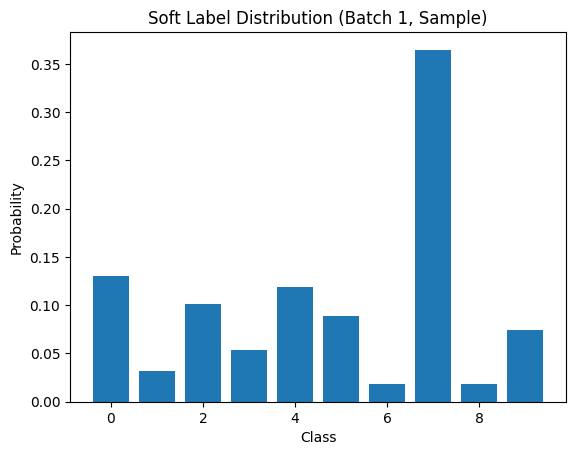

Sample Soft Label (Batch 2): [0.11500732 0.29387647 0.04298672 0.0548756  0.02842795 0.03487661
 0.03812538 0.04405961 0.1069235  0.24084084]


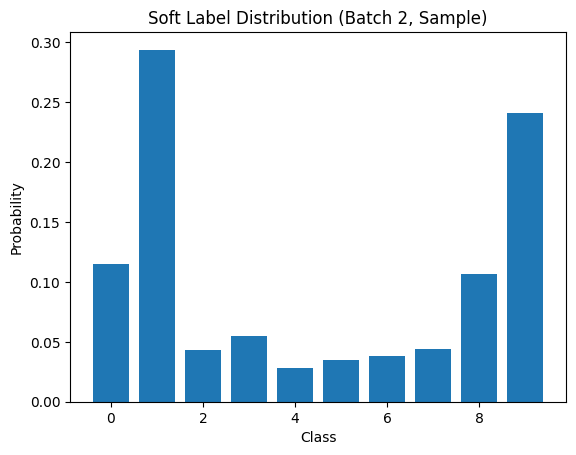

Total distilled samples: 50000
Distilled dataset generated.


In [118]:
# 2. Generate the distilled dataset
print("Generating distilled dataset...")
distilled_loader = generate_distilled_dataset(initial_model, trainloader,T = 5)  # Use the globally defined T
print("Distilled dataset generated.")

In [12]:
# 3. Initialize the Distilled Model
distilled_model = CIFAR10Model().to(device)  # Initialize Distilled Model
print("Distilled Model initialized.")

# 4. Train the Distilled Model
print("Training Distilled Model...")
train_losses_distilled, test_accuracies_distilled = train_distilled_model(
    distilled_model, distilled_loader, testloader, device,T=5
)
print("Distilled Model training completed.")


Distilled Model initialized.
Training Distilled Model...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1881, Test Accuracy: 29.67%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1273, Test Accuracy: 36.10%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1075, Test Accuracy: 39.97%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0959, Test Accuracy: 43.36%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0875, Test Accuracy: 45.45%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0792, Test Accuracy: 48.59%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0714, Test Accuracy: 50.22%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0650, Test Accuracy: 52.12%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0585, Test Accuracy: 52.53%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0544, Test Accuracy: 56.36%
Epoch 11, LR: 0.01600, Momentum: 0.72000, Train Loss: 0.0485, Test Accuracy: 56.37%
Epoch 12, LR: 0.01600, Momen

In [50]:
# Save the trained Distilled Model
torch.save(distilled_model.state_dict(), "distilled_model.pth")
print("Distilled Model saved as 'distilled_model.pth'.")


Distilled Model saved as 'distilled_model.pth'.


In [51]:

print("Current working directory:", os.getcwd())
print("Files in working directory:")
print(os.listdir(os.getcwd()))

Current working directory: /kaggle/working
Files in working directory:
['.virtual_documents', 'distilled_model.pth']


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


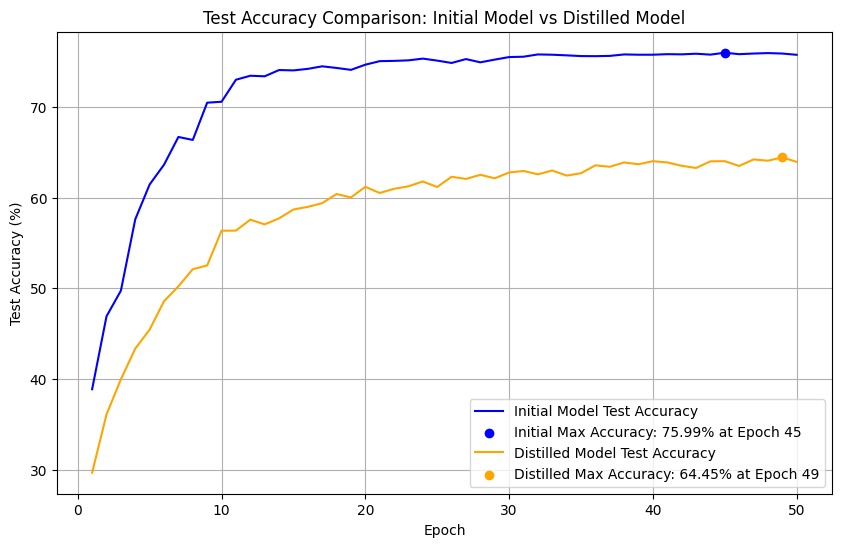

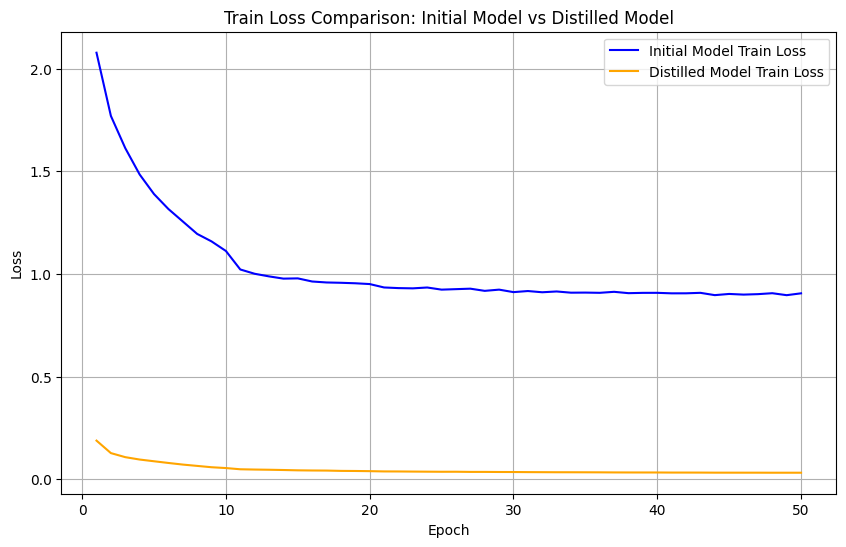

In [49]:
# Save results for both models
results_initial = {'test_accuracies': test_accuracies, 'train_losses': train_losses}
results_distilled = {'test_accuracies': test_accuracies_distilled, 'train_losses': train_losses_distilled}

# Plotting Test Accuracy Comparison
plt.figure(figsize=(10, 6))
# Initial Model Accuracy
plt.plot(range(1, 51), results_initial['test_accuracies'], label="Initial Model Test Accuracy", color='blue')
max_acc_initial = max(results_initial['test_accuracies'])
max_epoch_initial = results_initial['test_accuracies'].index(max_acc_initial) + 1
plt.scatter(max_epoch_initial, max_acc_initial, color='blue', label=f"Initial Max Accuracy: {max_acc_initial:.2f}% at Epoch {max_epoch_initial}")

# Distilled Model Accuracy
plt.plot(range(1, 51), results_distilled['test_accuracies'], label="Distilled Model Test Accuracy", color='orange')
max_acc_distilled = max(results_distilled['test_accuracies'])
max_epoch_distilled = results_distilled['test_accuracies'].index(max_acc_distilled) + 1
plt.scatter(max_epoch_distilled, max_acc_distilled, color='orange', label=f"Distilled Max Accuracy: {max_acc_distilled:.2f}% at Epoch {max_epoch_distilled}")

# Plot Settings
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison: Initial Model vs Distilled Model")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Train Loss Comparison
plt.figure(figsize=(10, 6))
# Initial Model Loss
plt.plot(range(1, 51), results_initial['train_losses'], label="Initial Model Train Loss", color='blue')
# Distilled Model Loss
plt.plot(range(1, 51), results_distilled['train_losses'], label="Distilled Model Train Loss", color='orange')

# Plot Settings
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison: Initial Model vs Distilled Model")
plt.legend()
plt.grid(True)
plt.show()


# Robustness Evaluation Against Adversarial Attacks

In [77]:
def generate_pgd_adversarial_sample(model, inputs, labels, epsilon=0.3, alpha=0.01, num_iter=40):
    """
    Generate adversarial samples using PGD.
    Args:
        model: The model to attack.
        inputs: Original inputs.
        labels: True labels for the inputs.
        epsilon: Maximum perturbation size.
        alpha: Step size for each iteration.
        num_iter: Number of iterations.
    Returns:
        Adversarially perturbed inputs.
    """
    perturbed_inputs = inputs.clone().detach().requires_grad_(True).to(inputs.device)

    for _ in range(num_iter):
        outputs = model(perturbed_inputs)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Update perturbation
        perturbed_inputs = perturbed_inputs + alpha * perturbed_inputs.grad.sign()
        perturbed_inputs = torch.clamp(perturbed_inputs, inputs - epsilon, inputs + epsilon)  # Project to epsilon-ball
        perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)  # Ensure valid pixel range
        perturbed_inputs = perturbed_inputs.detach().requires_grad_(True)

    return perturbed_inputs


In [114]:
def train_robustness_model(distilled_model, distilled_loader, testloader, device, T):
    """
    Train a Distilled Model on the dataset with soft labels and output accuracy for each epoch.
    Args:
        distilled_model: Initialized Distilled Model to train.
        distilled_loader: DataLoader with distilled dataset.
        testloader: DataLoader with test dataset for accuracy evaluation.
        device: The device used for computation (CPU or GPU).
        max_epochs: Maximum number of epochs to train (default is 80).
    Returns:
        Train Losses and Test Accuracies.
    """
    # Initialize weights (Xavier initialization)
    for m in distilled_model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Define optimizer, learning rate scheduler, and loss function
    initial_lr = 0.02  # Adjusted learning rate
    initial_momentum = 0.9  # Adjusted momentum
    optimizer = torch.optim.SGD(distilled_model.parameters(), lr=initial_lr, momentum=initial_momentum, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)  # Adjusted gamma

    # Store training statistics
    train_losses_distilled = []
    test_accuracies_distilled = []
    current_momentum = initial_momentum

    # Training loop
    for epoch in range(15):  
        total_loss = 0.0
        distilled_model.train()

        # Adjust momentum dynamically every 20 epochs
        if epoch % 10 == 0:
            current_momentum = max(initial_momentum * (0.5 ** (epoch // 10)), 0.1)
            for param_group in optimizer.param_groups:
                param_group['momentum'] = current_momentum

        # Training over the distilled dataset
        for inputs, soft_labels in distilled_loader:
            inputs, soft_labels = inputs.to(device), soft_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            #outputs = distilled_model(inputs)
            # 计算学生模型的概率分布（保持温度 T 与教师模型一致）
            outputs = torch.nn.functional.softmax(distilled_model(inputs) / T, dim=1)
    

            # KL Divergence Loss
            loss = torch.nn.functional.kl_div(torch.log(outputs + 1e-8), soft_labels, reduction="batchmean")

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(distilled_model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            total_loss += loss.item()

        # Learning rate scheduler step
        scheduler.step()

        # Evaluate on the test set
        test_accuracy = evaluate_model(distilled_model, testloader)
        train_losses_distilled.append(total_loss / len(distilled_loader))
        test_accuracies_distilled.append(test_accuracy)

        # Print epoch statistics
        print(
            f"Epoch {epoch+1}, LR: {optimizer.param_groups[0]['lr']:.5f}, Momentum: {current_momentum:.5f}, "
            f"Train Loss: {train_losses_distilled[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%"
        )

    return train_losses_distilled, test_accuracies_distilled


In [115]:
def test_robustness(model, testloader, attack_method='pgd', epsilon=0.2, alpha=0.01, num_iter=30, noise_level=0.2):
    """
    Test model robustness under adversarial or noisy conditions.
    Args:
        model: The model to test.
        testloader: DataLoader for test data.
        attack_method: 'pgd' or 'noisy'.
        epsilon: Perturbation size for adversarial attack.
        alpha: Step size for PGD attack.
        num_iter: Number of iterations for PGD.
        noise_level: Noise level for noisy attack.
    Returns:
        Accuracy of the model under the specified attack.
    """
    model.eval()
    correct = 0
    total = 0

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        if attack_method == 'pgd':
            # Use PGD attack
            perturbed_inputs = generate_pgd_adversarial_sample(model, inputs, labels, epsilon, alpha, num_iter)
        elif attack_method == 'noisy':
            # Add random noise
            noise = torch.randn_like(inputs) * noise_level
            perturbed_inputs = torch.clamp(inputs + noise, 0, 1)
        else:
            raise ValueError("Unsupported attack method.")

        outputs = model(perturbed_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total  # Return accuracy


# Robustness Comparison of Distilled Models at Different Temperatures

generate_distilled_dataset with T=1...
T=1


<ipython-input-116-54ac1b9b963b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_model.load_state_dict(torch.load("/kaggle/input/newmodelpth/initial_model.pth", map

Sample Soft Label (Batch 1): [1.2020171e-01 6.7967258e-04 8.9072651e-04 4.8127290e-04 4.4024031e-04
 2.2124559e-05 5.6750843e-05 2.8173523e-05 8.7300116e-01 4.1982252e-03]


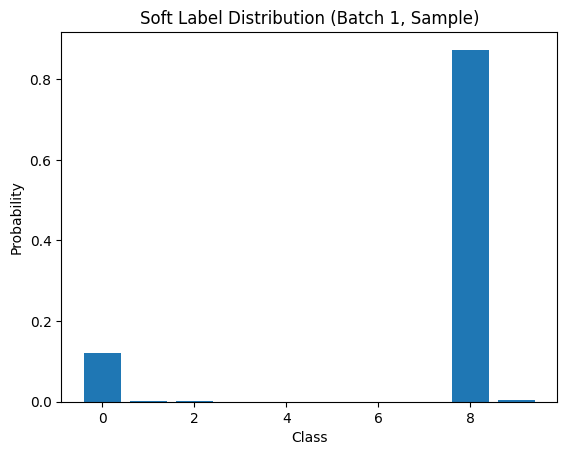

Sample Soft Label (Batch 2): [1.87467560e-02 8.41424525e-01 1.36114279e-04 7.07969521e-05
 1.50918650e-05 6.16647230e-06 4.11108922e-05 1.09140365e-05
 5.48929162e-02 8.46556500e-02]


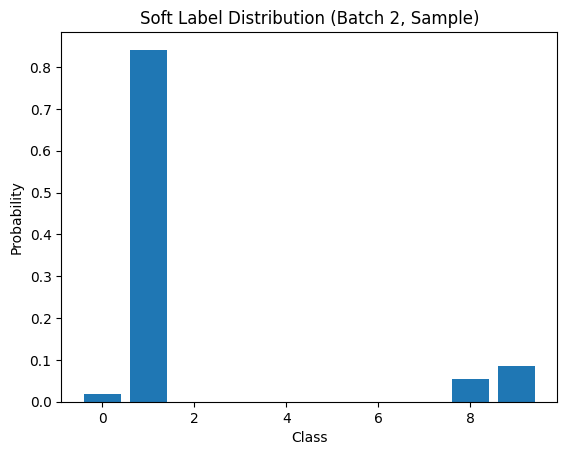

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=1...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 1.0295, Test Accuracy: 42.75%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.7116, Test Accuracy: 51.34%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.5520, Test Accuracy: 57.62%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.4293, Test Accuracy: 59.84%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.3444, Test Accuracy: 64.61%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.2869, Test Accuracy: 67.59%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.2437, Test Accuracy: 68.48%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.2114, Test Accuracy: 68.91%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1886, Test Accuracy: 71.23%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.1698, Test Accuracy: 71.55%
Epoch 11, LR: 0.01600, Momentum: 0.

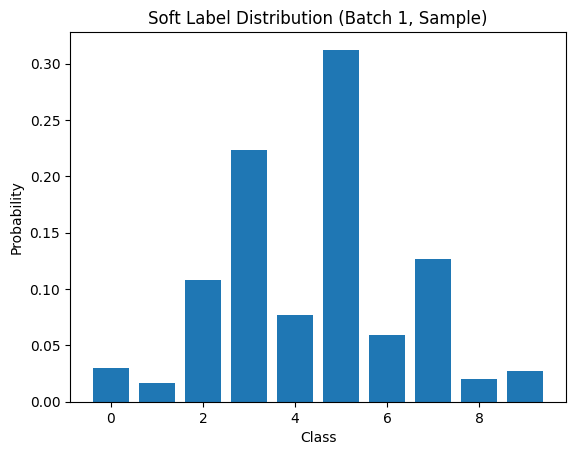

Sample Soft Label (Batch 2): [0.1009782  0.05040936 0.10097665 0.09167796 0.13875492 0.10717174
 0.04985563 0.2313631  0.03367813 0.09513433]


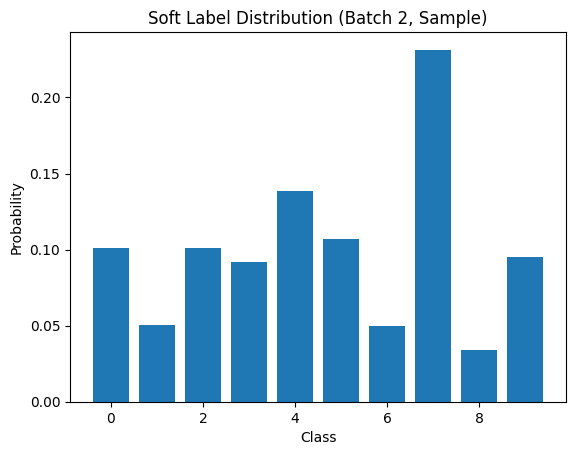

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=5...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1958, Test Accuracy: 28.38%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1321, Test Accuracy: 35.87%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.1075, Test Accuracy: 39.89%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0956, Test Accuracy: 42.68%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0864, Test Accuracy: 45.32%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0786, Test Accuracy: 47.26%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0710, Test Accuracy: 47.67%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0639, Test Accuracy: 51.75%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0592, Test Accuracy: 53.20%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0532, Test Accuracy: 55.56%
Epoch 11, LR: 0.01600, Momentum: 0.

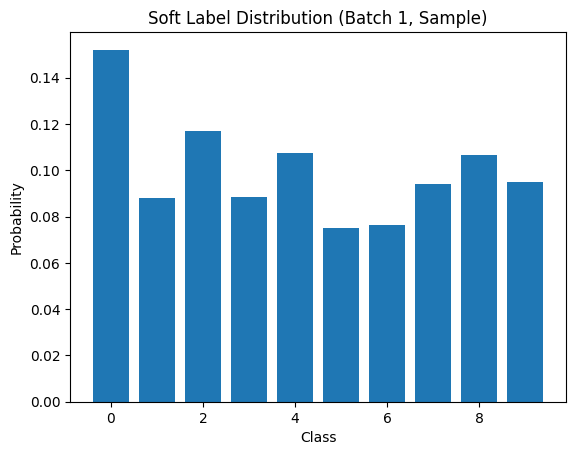

Sample Soft Label (Batch 2): [0.10270313 0.07902991 0.11866444 0.10589543 0.11277075 0.09979398
 0.09694374 0.10734449 0.08901148 0.08784255]


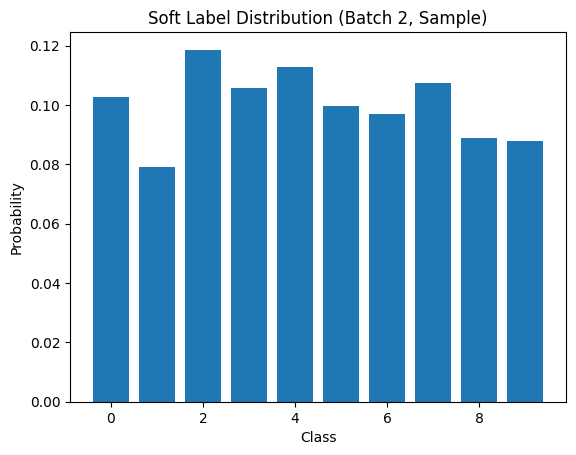

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=10...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0593, Test Accuracy: 10.01%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0557, Test Accuracy: 21.27%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0454, Test Accuracy: 27.28%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0394, Test Accuracy: 29.69%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0352, Test Accuracy: 33.26%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0324, Test Accuracy: 34.20%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0308, Test Accuracy: 34.63%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0294, Test Accuracy: 35.93%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0282, Test Accuracy: 36.40%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0273, Test Accuracy: 37.13%
Epoch 11, LR: 0.01600, Momentum: 0

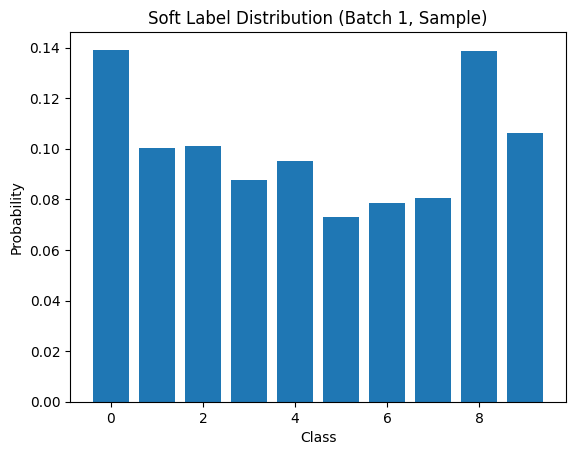

Sample Soft Label (Batch 2): [0.14529079 0.17476057 0.07516553 0.06987789 0.06496242 0.0562255
 0.06045425 0.0717134  0.11973987 0.16180974]


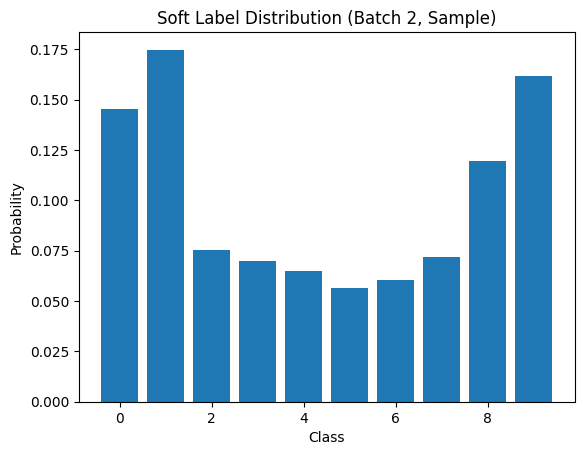

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=15...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0265, Test Accuracy: 10.12%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0262, Test Accuracy: 10.74%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0254, Test Accuracy: 16.99%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0234, Test Accuracy: 18.30%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0213, Test Accuracy: 20.76%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0198, Test Accuracy: 23.48%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0183, Test Accuracy: 26.64%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0168, Test Accuracy: 28.26%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0158, Test Accuracy: 30.95%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0151, Test Accuracy: 32.90%
Epoch 11, LR: 0.01600, Momentum: 0

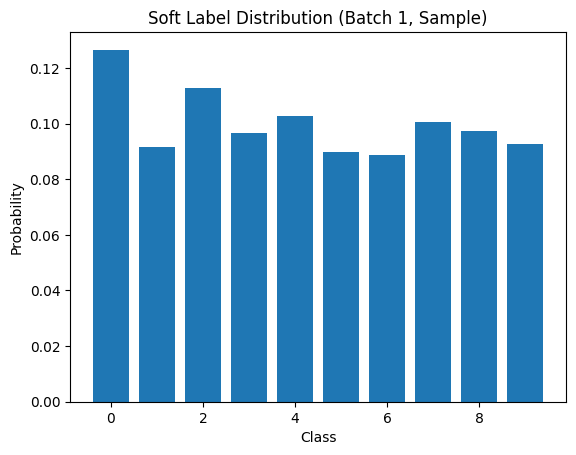

Sample Soft Label (Batch 2): [0.09327459 0.08813275 0.10366804 0.11189185 0.10516754 0.1072363
 0.10497095 0.10122252 0.09159771 0.0928378 ]


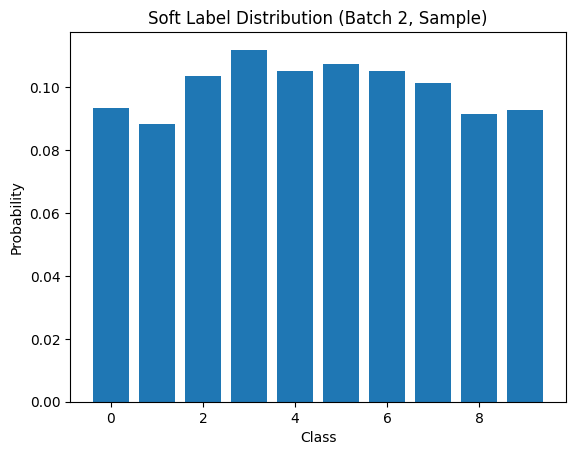

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=20...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0149, Test Accuracy: 9.77%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0147, Test Accuracy: 10.00%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0146, Test Accuracy: 10.24%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0144, Test Accuracy: 14.58%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0141, Test Accuracy: 16.56%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0135, Test Accuracy: 17.50%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0126, Test Accuracy: 19.54%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0118, Test Accuracy: 21.62%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0113, Test Accuracy: 22.80%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0110, Test Accuracy: 24.19%
Epoch 11, LR: 0.01600, Momentum: 0.

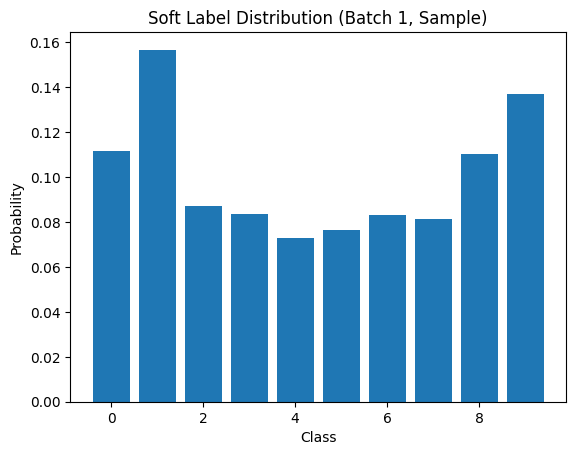

Sample Soft Label (Batch 2): [0.11908237 0.10655639 0.10172338 0.09319229 0.09631454 0.08679483
 0.08723536 0.09510434 0.10663255 0.10736392]


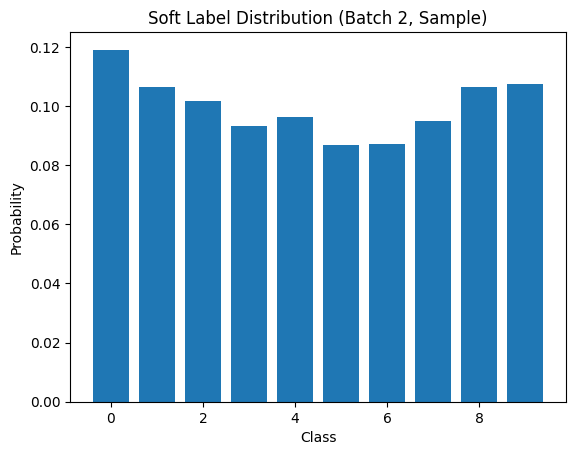

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=25...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0095, Test Accuracy: 10.00%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0095, Test Accuracy: 10.00%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0094, Test Accuracy: 10.00%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0094, Test Accuracy: 10.00%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0093, Test Accuracy: 10.00%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0093, Test Accuracy: 10.00%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0092, Test Accuracy: 10.47%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0090, Test Accuracy: 13.86%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0089, Test Accuracy: 15.73%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0087, Test Accuracy: 17.10%
Epoch 11, LR: 0.01600, Momentum: 0

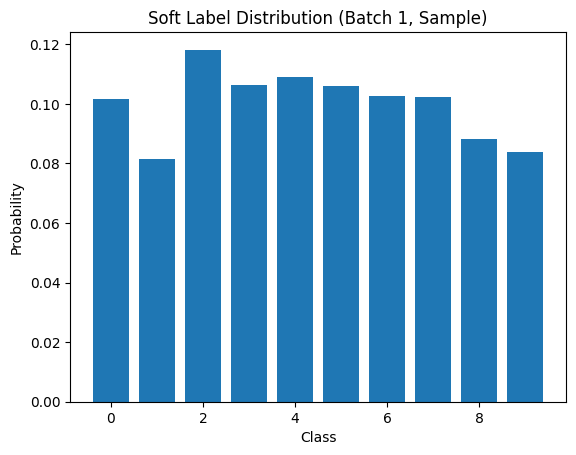

Sample Soft Label (Batch 2): [0.09236351 0.0773536  0.11523917 0.10700833 0.12411892 0.10659511
 0.1103901  0.10366954 0.08223929 0.08102238]


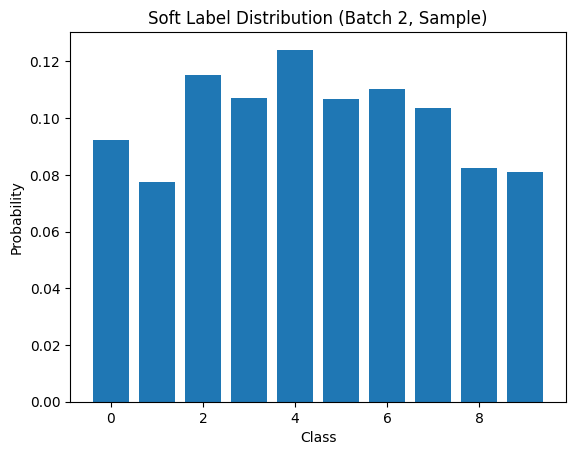

Total distilled samples: 50000
Distilled dataset generated.
Distilled Models create successfully
Training Distilled Model with T=30...
Epoch 1, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0066, Test Accuracy: 10.00%
Epoch 2, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0066, Test Accuracy: 10.00%
Epoch 3, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0065, Test Accuracy: 10.01%
Epoch 4, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0065, Test Accuracy: 10.01%
Epoch 5, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0065, Test Accuracy: 10.07%
Epoch 6, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0065, Test Accuracy: 9.99%
Epoch 7, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0064, Test Accuracy: 9.71%
Epoch 8, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0064, Test Accuracy: 10.97%
Epoch 9, LR: 0.02000, Momentum: 0.90000, Train Loss: 0.0064, Test Accuracy: 13.23%
Epoch 10, LR: 0.01600, Momentum: 0.90000, Train Loss: 0.0063, Test Accuracy: 13.95%
Epoch 11, LR: 0.01600, Momentum: 0.4

In [116]:
temperatures = [1, 5, 10, 15, 20, 25, 30]
results = {}

for T in temperatures:
    
    initial_model = CIFAR10Model().to(device)
    initial_model.load_state_dict(torch.load("/kaggle/input/newmodelpth/initial_model.pth", map_location=device))
    initial_model.eval()


    print(f"generate_distilled_dataset with T={T}...")
    distilled_loader = generate_distilled_dataset(initial_model, trainloader,T)  # Use the globally defined T
    print("Distilled dataset generated.")
    
    
    distilled_model = CIFAR10Model().to(device)
    
    print(f"Distilled Models create successfully")
    
    print(f"Training Distilled Model with T={T}...")
    # Train the Distilled Model for 30 epochs
    train_losses, test_accuracies = train_robustness_model(
        distilled_model, distilled_loader, testloader, device, T
    )
    
    # Test robustness with PGD
    distilled_model.eval()
    adv_accuracy = test_robustness(distilled_model, testloader, attack_method='pgd', epsilon=0.2, alpha=0.01, num_iter=30)
    adv_success_rate = 100 - adv_accuracy
    print(f"T={T}, PGD Attack Success Rate: {adv_success_rate:.2f}%")

    results[T] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'adversarial_success_rate': adv_success_rate,
    }


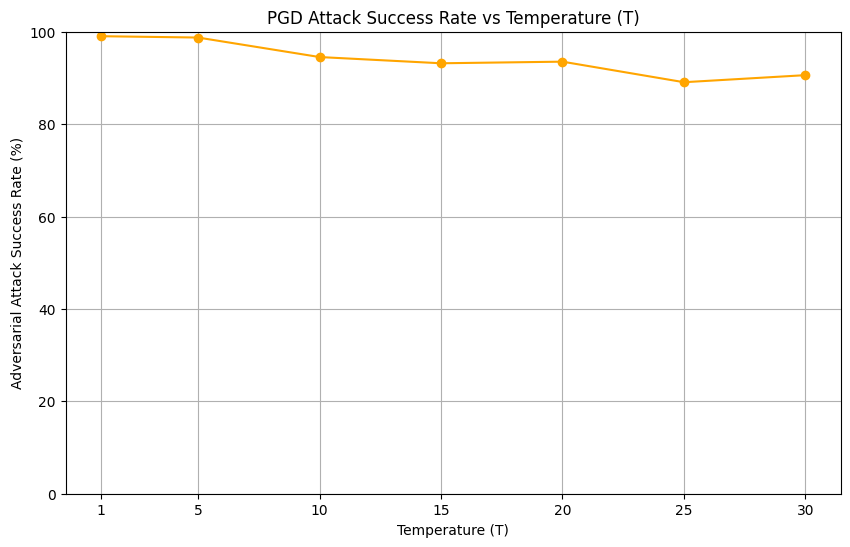

In [117]:

# 绘图
plt.figure(figsize=(10, 6))
temperatures = list(results.keys())
success_rates = [results[T]['adversarial_success_rate'] for T in temperatures]

plt.plot(temperatures, success_rates, marker='o', linestyle='-', color='orange')
plt.title('PGD Attack Success Rate vs Temperature (T)')
plt.xlabel('Temperature (T)')
plt.ylabel('Adversarial Attack Success Rate (%)')
plt.grid(True)
plt.xticks(temperatures)
plt.ylim(0, 100)
plt.show()


# compare initial model and distilled model

In [120]:
#load Initial Model
initial_model = CIFAR10Model().to(device)
initial_model.load_state_dict(torch.load("/kaggle/input/newmodelpth/initial_model.pth", map_location=device))
initial_model.eval()

# Initial Model 
initial_adv_accuracy = test_robustness(
    initial_model, 
    testloader, 
    attack_method='pgd',  
    epsilon=0.2,          
    alpha=0.01,           
    num_iter=30           
)

initial_adv_success_rate = 100 - initial_adv_accuracy
print(f"Initial Model PGD Attack Success Rate: {initial_adv_success_rate:.2f}%")



<ipython-input-120-9837a90017fa>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_model.load_state_dict(torch.load("/kaggle/input/newmodelpth/initial_model.pth", map

Initial Model PGD Attack Success Rate: 99.36%


TypeError: '<' not supported between instances of 'str' and 'int'

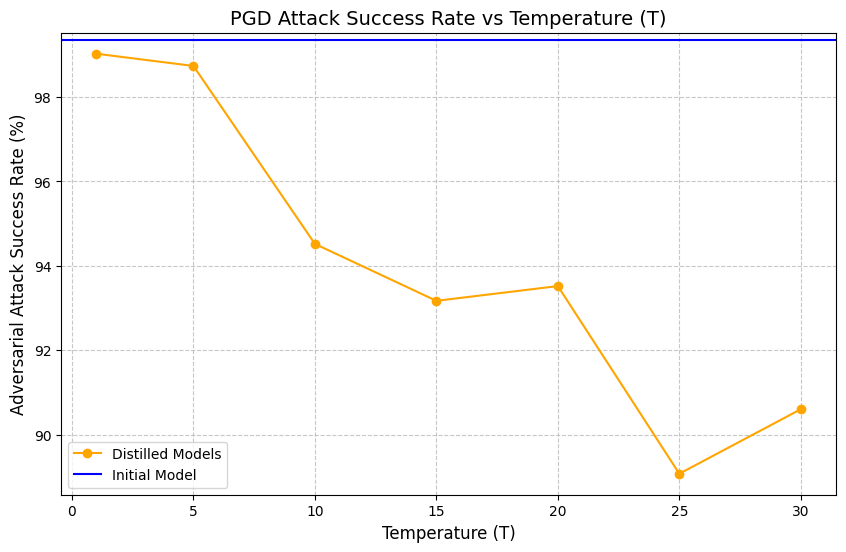

In [122]:
results['initial_model'] = {
    'adversarial_success_rate': initial_adv_success_rate
}

# 绘图时，包含 Initial Model 的结果
plt.figure(figsize=(10, 6))
temperatures = list(results.keys())
success_rates = [results[T]['adversarial_success_rate'] for T in temperatures]

plt.plot(temperatures[:-1], success_rates[:-1], marker='o', linestyle='-', color='orange', label='Distilled Models')  # Distilled Models
plt.axhline(y=initial_adv_success_rate, color='blue', linestyle='-', label='Initial Model')  # Initial Model

plt.title('PGD Attack Success Rate vs Temperature (T)', fontsize=14)
plt.xlabel('Temperature (T)', fontsize=12)
plt.ylabel('Adversarial Attack Success Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(temperatures[:-1] + ['Initial Model'])
plt.ylim(0, 100)
plt.show()
